<a href="https://colab.research.google.com/github/Datamin-D/Projects/blob/main/%5BTerm_proj%5D%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%A7%88%EC%9D%B4%EB%8B%9D_%EA%B3%A0%EA%B0%9D%EA%B2%BD%ED%97%98_%EB%94%94%EC%9E%90%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

토픽 모델링 시험

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy as sp
import sklearn
import sys

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy import linalg

!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pickle
import string


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Importing Libraries & Df

In [ ]:
ld_df = pd.read_csv('/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/living_dec_df.csv')
sd_df = pd.read_csv('/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/sal_dot_df.csv')
sq_df = pd.read_csv('/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/sal_question_df.csv')

In [ ]:
# 결측치 --> 없음.
dfs = [ld_df, sd_df, sq_df]
df = dfs[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      2845 non-null   int64 
 1   title           2845 non-null   object
 2   content         2845 non-null   object
 3   writer          2842 non-null   object
 4   date            2845 non-null   object
 5   view            2845 non-null   object
 6   recommendation  2845 non-null   object
 7   board           2845 non-null   object
 8   url             2845 non-null   object
dtypes: int64(1), object(8)
memory usage: 200.2+ KB


In [ ]:
def clean_text(text):
    text = re.sub('http[s]?://\S+', '', text) # http url 제거
    text = re.sub('\S*@\S*\s?', '', text) # 기자 emails 제거
    text = re.sub(r'\[.*?\]', '', text) # 대괄호안에 텍스트 제거 : 뉴스이름 + 기자이름
    text = re.sub(r'\w*\d\w*', '', text) # 숫자 포함하는 텍스트 제거
    text = re.sub('[?.,;:|\)*~"`’!^\-_+<>@\#$%&-=#}※]', '', text)#특수문자 이모티콘 제거
    text = re.sub("\n", '', text) #개행문자 제거
    text = re.sub("\r", '', text) #개행문자 제거
    text = re.sub("\xa0", '', text) #개행문자 제거
    text = re.sub(r'Copyright .* rights reserved', '', text) # "Copyright all rights reserved" 제거
    return text


In [ ]:
def preprocessing(text):
    # 특수문자나 이모티콘 등 아래의 특수기호들을 제거합니다(%등은 남김).
    text = re.sub('[?.,;:|\)*~`’!\-_+<>@\#$%&-=#}※]', '', text)
    #특수 문자 중 ^는 살려봄. 감성분석에서 도움 될까봐.
    
    # 위에서 특수문자를 제거한 text에서 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text


In [ ]:
df['text_clean'] = pd.DataFrame(df['content'].apply(lambda x: clean_text(x)))
df['text_clean']

0        재식이를 너무 많이 사랑해주셔서 깜짝 놀랐다 모두 예쁜걸 보는 눈은 비슷하다 인형...
1        인사이동이 있었다 나도 이동하게 되어 몸과 마음이 너무 바쁘고 힘들었다 오랜기간 ...
2                 덕질로 그렸었어요  그리면서 레번클로가 참 멋지다고 생각이 들더라고요 
3        리빙데코 게시판 회원 여러분 안녕하셨죠 오랜만이에요 약 한 달 전에 이렇게 조그맣...
4         둘째 임신하면서 포크아트라는 걸 했었어요 그 이후 포쉘린도 조금하고 지금은 그냥...
                              ...                        
2840      거실이사오면서 거실에 책장을 짜 넣었어요  두 아들눔들이 책을 좋아하는 아이들로...
2841     장보러 가서 은근슬쩍 쇼핑카트에 하나씩 던져넣는 미니어쳐에요 까페 시리즈인데 넘 ...
2842     이웃덕분에 생긴 원단으로초간단 스커트만들기오랜만에 과정샷찍었어요원단은 후들거리면서...
2843                                                구경하세요
2844                                                     
Name: text_clean, Length: 2845, dtype: object

In [ ]:
df['text_clean'].loc[13]

' 지난 목요일은 미국의 추수감사절이고 그래서 아이들과 남편 학교는 수요일부터 일요일까지 긴 연휴를 맞이했습니다저는 학교가 일찍 종강해서 겨울방학이나 다름없구요추수감사절 세일이라 털실 두 개를 사면 하나가 공짜라며 선전하는 전단지를 보고 둘리양과 함께 쇼핑을 다녀왔어요유치원 다닐 때 떠준 케이프가 이제는 작아져서 큰 것으로 새로 만들어 주기로 했죠원래 인터넷에서 찾았던 디자인은 주름을 플레어로 풍성하게 넣고 떠서 어깨에 두르면 케이프 허리에 두르면 스커트가 되는 것이었는데ㅠㅠ뜨다 보니 실이 모자랄 것 같아서 급 코를 줄여 마무리 했더니 이렇게 짤뚱한 케이프가 되고 말았어요치마로 입기에는 너무 짧아요ㅠㅠ앞모습이나 뒷모습이나 전혀 다를 것이 없습니다뭐 그래서 뒤집어 쓰고 입기에는 편하겠죠 털실 두 뭉치를 사서 케이프를 뜨고 뽀나스로 공짜로 받아온 털실 한 개로는 모자를 만들었어요이것도 뭐 그냥 단순하게둥글게 뜨면서 코를 늘려가다가막판에는 줄여서 머리둘레에다 맞추는디자인이랄 것도 없이 막 뜬 거랍니다 막손으로 한 뜨개질이지만 모델이 살려준 작품이에요 금손님들께 보여드리기 민망한 이틀간의 졸속 뜨개질 작품이라그냥 가기 민망해서 크리스마스 장식 뜨개질 몇 개 더 보여드릴게요 대문에 걸린 리스그 위에 눈송이 갈랜드실내에는 별이 빛나는 문제가 설거지할 때 가장 가까이 보이는 벽에는 나머지 뜨개질 모티프를 붙여두었어요이제 크리스마스가 지나면 저걸 하나 둘 곶감 빼먹듯이 떼서 설거지를 할 거에요크리스마스 다음날 하는 세일에서 큰 트리를 사려고 올해까지만 작은 트리로 장식하기로 했어요모두들 행복한 연말 보내세요'

# 띄어쓰기, 맞춤법 등 수정

In [ ]:
##코드 작성

# 형태소 분석

In [ ]:
!pip install konlpy
from konlpy.tag import Okt

     |████████████████████████████████| 19.4MB 433kB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 460kB 53.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# 형태소 쪼개기
okt = Okt()
texts_ko = [okt.morphs(doc) for doc in df.text_clean]
texts_ko[0]


['재',
 '식',
 '이를',
 '너무',
 '많이',
 '사랑',
 '해주셔서',
 '깜짝',
 '놀랐다',
 '모두',
 '예쁜',
 '걸',
 '보는',
 '눈',
 '은',
 '비슷하다',
 '인형',
 '에',
 '관심',
 '없던',
 '사람',
 '들',
 '에게도',
 '재',
 '식이',
 '는',
 '중국',
 '작가',
 '가',
 '만든',
 '인형',
 '이다',
 '지금',
 '은',
 '절판',
 '되었고',
 '워낙',
 '소량',
 '만',
 '만들어',
 '구입',
 '하기',
 '어려웠다',
 '예쁜건',
 '나눠야',
 '하기에',
 '저',
 '와',
 '함께',
 '인형',
 '놀이',
 '하실래요',
 '재',
 '식이',
 '좀',
 '재워주세요',
 '지난',
 '여름',
 '나',
 '는',
 '재',
 '식',
 '이를',
 '위',
 '하여',
 '나도',
 '못',
 '덮는',
 '최고급',
 '린넨',
 '이불',
 '요',
 '를',
 '만들었다실은',
 '내',
 '블라우스',
 '만들고',
 '남은',
 '천이',
 '지만',
 '다다미',
 '깔은',
 '우리',
 '집',
 '안방',
 '우리',
 '집',
 '안방',
 '에는',
 '아무',
 '것',
 '도',
 '없다에서',
 '재',
 '식이',
 '는',
 '혼자',
 '낮잠',
 '을',
 '잤다',
 '낮잠',
 '재우기',
 '놀이',
 '아이',
 '가',
 '한참',
 '클',
 '때',
 '는',
 '얼마나',
 '힘든',
 '일',
 '이었던가',
 '그런데',
 '세월',
 '이',
 '지나니',
 '놀이',
 '가',
 '된다']

불용어 제거

In [ ]:
# 명사 추출 
text_noun=[okt.nouns(doc) for doc in df.text_clean]
print(text_noun[0])


# 동사, 형용사 추출

## 코드 작성

In [ ]:
print(text_noun[0])

['재', '사랑', '깜짝', '모두', '걸', '눈', '인형', '관심', '사람', '재', '식이', '중국', '작가', '인형', '지금', '절판', '워낙', '소량', '구입', '저', '인형', '재', '식이', '좀', '지난', '여름', '나', '재', '위', '최고급', '린넨', '이불', '요', '내', '블라우스', '천이', '다다미', '우리', '집', '안방', '우리', '집', '안방', '아무', '것', '재', '식이', '혼자', '낮잠', '낮잠', '놀이', '아이', '한참', '때', '얼마나', '일', '세월', '놀이']


In [ ]:
# 불용어 제거

import json
path = '/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/'
with open(path + 'korean_stopwords (1).json', encoding = 'UTF-8' ) as f:
    stopwords = json.load(f)
stopwords.extend(['고','씨']) #추가할 불용어
stopwords.remove('^') # 불용어 리스트에서 빼내기

In [ ]:
df['text_tokenized'] = text_noun
df['text_tokenized'] = df.text_tokenized.apply(lambda x: [a for a in x if a not in stopwords])


word cloud

In [ ]:
# 리스트로되어있는거 차원 낮춰주는것.
def flatten(l):
    flatlist = []
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatlist.append(e)
        else:
            flatlist.append(elem)
        return flatlist


In [ ]:
data1 = df.text_tokenized.tolist()
data2 = flatten(data1)

In [ ]:
text = nltk.Text(data2) #nltk.Text로 변환. 왜? 뭐에 씀??
text

<Text: 재 사랑 깜짝 걸 눈 인형 관심 사람...>

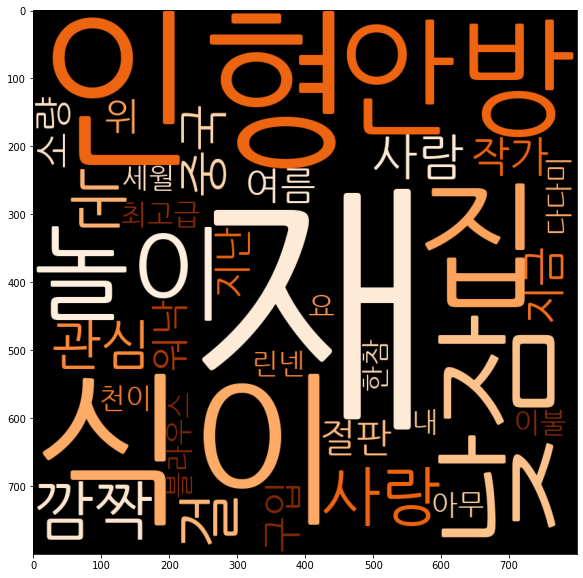

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
font_path='/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/NanumGothic.ttf'
wordclouds = WordCloud(width = 800, height = 800,background_color = 'Black', font_path= font_path,colormap = 'Oranges')

from collections import Counter
count = Counter(text)
wordclouds = wordclouds.generate_from_frequencies(count)
fig = plt.figure(figsize = (10,10))
plt.imshow(wordclouds)
plt.show()

# 2000개 글 중 n 의 토픽.. '재식이 인형'